In [1]:
from pytket import Circuit
from pytket.circuit import OpType, Op
from pytket.circuit.display import render_circuit_jupyter
from pytket_dqc.networks import NISQNetwork
from pytket_dqc.allocators import HypergraphPartitioning
from pytket_dqc.circuits import HypergraphCircuit
from pytket_dqc.packing import PacMan
from pytket_dqc.utils import DQCPass
from pytket_dqc.placement import Placement
from sympy import Symbol
from pytket.passes import SynthesiseTK

In [2]:
# import json
# with open("06_02_01.json") as f:
#     circuit = Circuit.from_dict(json.load(f))
# network = NISQNetwork(
#     [[0,1]],
#     {0: [0,1,2], 1: [3,4,5]}
# )
# t01 = Symbol("t0_1")
# t02 = Symbol("t0_2")
# t11 = Symbol("t1_1")
# t12 = Symbol("t1_2")
# t22 = Symbol("t2_2")
# t21 = Symbol("t2_1")
# t31 = Symbol("t3_1")
# t41 = Symbol("t4_1")
# t51 = Symbol("t5_1")
# t61 = Symbol("t6_1")
# t71 = Symbol("t7_1")
# circ_map = {t01: 0, t02:0, t11: 0, t21: 0, t12: 0, t22:0, t31: 0, t41: 0, t51: 0, t61: 0, t71: 0}
# circuit.symbol_substitution(circ_map)
# render_circuit_jupyter(circuit)
# circuit.free_symbols()

In [3]:
test_circuit = Circuit(6)
# This test circuit is comprised of sections
# designed to test various things

# Test that hyperedges on different servers are split
# Test that hyperedges split by (anti)diagonal gates
# are merged
cz = Op.create(OpType.CU1, 1)
test_circuit.add_gate(cz, [0,2])
test_circuit.add_gate(cz, [0,4])
test_circuit.Z(0).X(0)
test_circuit.add_gate(cz, [0,5])
test_circuit.add_gate(cz, [0,3])

# Test we can embed two CU1s with no Hadamard
# one Hadamard and two Hadamards
# S gates inserted to ensure angle of phase gates
# sum to integer
test_circuit.H(0)
test_circuit.Rz(0.5, 0)
test_circuit.add_gate(cz, [0,2])
test_circuit.Rz(0.5, 0) # 0 H
test_circuit.add_gate(cz, [0,3])
test_circuit.H(0) # 1 H
test_circuit.add_gate(cz, [0,2]) # NOT mergeable
test_circuit.Rz(0.5, 0)
test_circuit.H(0) # 2 H
test_circuit.Rz(0.27, 0) # Random phase that should have no effect
test_circuit.H(0)
test_circuit.add_gate(cz, [0,2])
test_circuit.H(0)
test_circuit.add_gate(cz, [0,3]) # This gate is mergeable

# Test that local and 3rd party server CU1s break embeddability
test_circuit.H(0)
test_circuit.add_gate(cz, [0,1]) # Local CU1
test_circuit.H(0)
test_circuit.add_gate(cz, [0,2]) # NOT mergeable
test_circuit.H(0)
test_circuit.add_gate(cz, [0,4]) # 3rd party CU1
test_circuit.H(0)
test_circuit.add_gate(cz, [0,2]) # NOT mergeable

# Test that conflicts are identified correctly
test_circuit.H(0).H(2)
test_circuit.add_gate(cz, [0,2])
test_circuit.H(0).H(2)
test_circuit.add_gate(cz, [0,2])

placement_dict = {
    0: 0, 1: 0, 2: 1, 3: 1, 4: 2, 5: 2,
}
for i in range(6, 19):
    placement_dict[i] = 0

In [4]:
render_circuit_jupyter(test_circuit)
hyper_circ = HypergraphCircuit(test_circuit)
distributor = HypergraphPartitioning()
placement = Placement(placement_dict)
print(placement.placement)

{0: 0, 1: 0, 2: 1, 3: 1, 4: 2, 5: 2, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 15: 0, 16: 0, 17: 0, 18: 0}


In [5]:
pacman = PacMan(hyper_circ, placement)

In [16]:
print(pacman.merged_packets)

{0: [(P0, P3, P8), (P1, P2), (P4, P5), (P6,), (P7,), (P9,), (P10,), (P11,), (P12, P14), (P13,)], 1: [(P15,)], 2: [(P16, P18), (P17,)], 3: [(P19,)], 4: [(P20,)], 5: [(P21,)]}


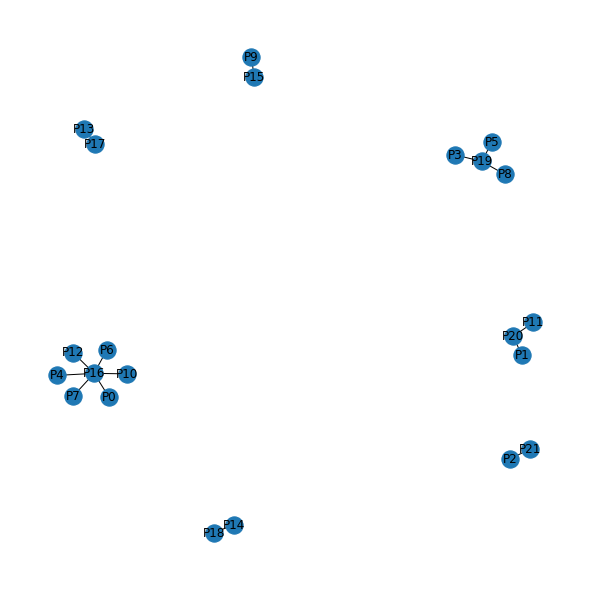

In [7]:
import networkx as nx
from networkx.algorithms import bipartite
g, topnodes = pacman.get_nx_graph_neighbouring()

nx.draw(g, with_labels = True)

7


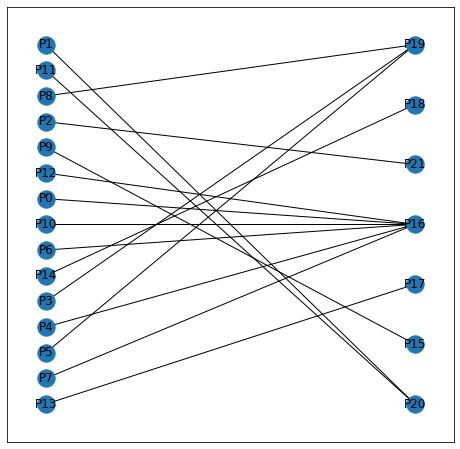

In [8]:
nx.draw_networkx(
    g,
    pos = nx.drawing.layout.bipartite_layout(g, topnodes), 
    width = 1)
matching = bipartite.maximum_matching(g, top_nodes = topnodes)
mvc = bipartite.to_vertex_cover(g, matching, top_nodes=topnodes)
print(len(mvc))

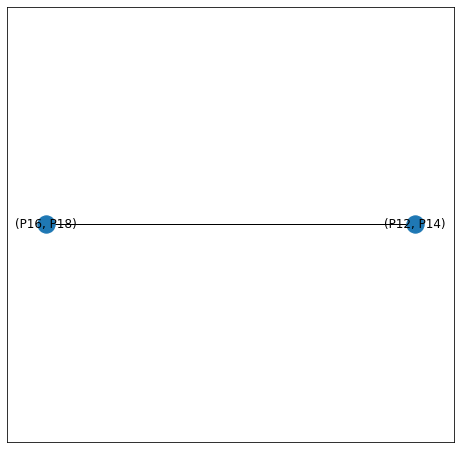

In [9]:
cg, topnodes = pacman.get_nx_graph_conflict()
nx.draw_networkx(
    cg,
    pos = nx.drawing.layout.bipartite_layout(cg, topnodes), 
    width = 1)